author: Diogo Silva

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
cd ~/QCThesis/

/home/chiroptera/workspace/QCThesis


In [6]:
import seaborn as sns
from sklearn.cluster import KMeans as KMeans_skl
import MyML.cluster.eac as eac
reload(eac)
import MyML.cluster.K_Means3 as K_Means3
reload(K_Means3)
import MyML.metrics.accuracy as determine_ci
reload(determine_ci)
import MyML.cluster.KMedoids as KMedoids
reload(KMedoids)

<module 'MyML.cluster.KMedoids' from 'MyML/cluster/KMedoids.pyc'>

# Helper functions

In [4]:
def stat_my_kmeans(data,nclusters,gtruth,rounds=20):
    nsamples=data.shape[0]
    all_acc = list()
    for r in xrange(rounds):
        iters="converge"
        kmeans_mode="numpy"

        grouper = K_Means3.K_Means(nclusters=nclusters, iters=iters, mode=kmeans_mode, cuda_mem='manual',tol=1e-4,max_iters=300)
        grouper._centroid_mode = "index"
        grouper.fit(data)

        ci=determine_ci.ConsistencyIndex(N=nsamples)
        accuracy=ci.score(gtruth,grouper.labels_,format='array')
        all_acc.append(accuracy)
        
        
    return np.mean(all_acc),np.var(all_acc),np.max(all_acc),np.min(all_acc)
    
def stat_skl_kmeans(data,nclusters,gtruth,rounds=20,init='random'):
    nsamples=data.shape[0]
    all_acc = list()
    for r in xrange(rounds):
        iters="converge"
        kmeans_mode="numpy"

        gSKL = KMeans_skl(n_clusters=nclusters,n_init=1,init=init)
        gSKL.fit(data)

        ci=determine_ci.ConsistencyIndex(N=nsamples)
        accuracy=ci.score(gtruth,gSKL.labels_,format='array')
        all_acc.append(accuracy)
        
        
    return np.mean(all_acc),np.var(all_acc),np.max(all_acc),np.min(all_acc)

In [5]:
def k_analysis(partition_files,ground_truth,nprots,iters="converge",rounds=20,files=True):
    nsamples=data.shape[0]
    all_acc = list()
    
    for r in xrange(rounds):
        prot_mode="random"

        estimator=eac.EAC(nsamples)
        estimator.fit(partition_files,files=files,assoc_mode='prot', prot_mode=prot_mode, nprot=nprots,build_only=True)

        kmeans_mode = "numpy"
        nclusters = np.unique(ground_truth).shape[0]

        grouper = K_Means3.K_Means(nclusters=nclusters, iters=iters, mode=kmeans_mode, cuda_mem='manual',tol=1e-4,max_iters=300)
        grouper._centroid_mode = "index"
        grouper.fit(estimator._coassoc)

        ci=determine_ci.ConsistencyIndex(N=nsamples)
        accuracy=ci.score(ground_truth,grouper.labels_,format='array')
        all_acc.append(accuracy)
    return np.mean(all_acc),np.var(all_acc),np.max(all_acc),np.min(all_acc)

def k_skl_analysis(partition_files,ground_truth,nprots,rounds=20,files=True):
    nsamples=data.shape[0]
    all_acc = list()
    
    for r in xrange(rounds):
        prot_mode="random"

        estimator=eac.EAC(nsamples)
        estimator.fit(partition_files,files=files,assoc_mode='prot', prot_mode=prot_mode, nprot=nprots,build_only=True)

        kmeans_mode = "numpy"
        nclusters = np.unique(ground_truth).shape[0]


        grouper = KMeans_skl(n_clusters=nclusters,n_init=1,init="random")
        grouper.fit(estimator._coassoc)
        
        ci=determine_ci.ConsistencyIndex(N=nsamples)
        accuracy=ci.score(ground_truth,grouper.labels_,format='array')
        all_acc.append(accuracy)
    return np.mean(all_acc),np.var(all_acc),np.max(all_acc),np.min(all_acc)

In [6]:
def formatPartition(partition):
    nclusters=np.unique(partition).shape[0]
    finalPartition=[list() for x in xrange(nclusters)]
    for n,c in partition:
        finalPartition[c].append(n)
        
    return finalPartition

def generatePartitions(data,npartitions,nclusters,iters=3):
    
    if type(nclusters) is list:
        clusterRange = True
        min_ncluster=nclusters[0]
        max_ncluster=nclusters[1]
    else:
        clusterRange = False
        k = nclusters
        
    partitions = list()
    
    mode = "numpy"
    for p in xrange(npartitions):
        if clusterRange:
            k = np.random.randint(min_ncluster,max_ncluster)
        
        grouper = K_Means3.K_Means(nclusters=k, iters=iters, mode=mode, cuda_mem='manual',tol=1e-4,max_iters=300)
        grouper._centroid_mode = "index"
        grouper.fit(data)
        partitions.append(grouper.partition)
        
    return partitions
        
def generatePartitionsSKL(data,npartitions,nclusters,iters=3):
    
    if type(nclusters) is list:
        clusterRange = True
        min_ncluster=nclusters[0]
        max_ncluster=nclusters[1]
    else:
        clusterRange = False
        k = nclusters
        
    partitions = list()
    
    mode = "numpy"
    for p in xrange(npartitions):
        if clusterRange:
            k = np.random.randint(min_ncluster,max_ncluster)
        
        gSKL = KMeans_skl(n_clusters=k,n_init=1,init="random",max_iter=iters)
        gSKL.fit(data)
        partitions.append(formatPartition(gSKL.labels_))
        
    return partitions
    

# Get data

In [7]:
from sklearn import datasets
irisDS = datasets.load_iris()
iris=irisDS.data
iris_gt=irisDS.target

# Generate partitions

In [9]:
npartitions=30
iters=3
data=iris

nclusters=10
partitions_my_10 = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)
partitions_skl_10 = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)

if type(nclusters) is not list:
    allGood=True
    for p in xrange(npartitions):
        if len(partitions_my_10[p]) != nclusters:
            print 'my partition {} has {} clusters instead of {}'.format(p,len(partitions_my_10[p]),nclusters)
            allGood=False
        if len(partitions_skl_10[p]) != nclusters:
            print 'skl partition {} has {} clusters instead of {}'.format(p,len(partitions_skl_10[p]),nclusters)
            allGood=False
    if allGood:
        print 'All partitions have good number of clusters.'

nclusters=6
partitions_my_6 = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)
partitions_skl_6 = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)

if type(nclusters) is not list:
    allGood=True
    for p in xrange(npartitions):
        if len(partitions_my_6[p]) != nclusters:
            print 'my partition {} has {} clusters instead of {}'.format(p,len(partitions_my_6[p]),nclusters)
            allGood=False
        if len(partitions_skl_6[p]) != nclusters:
            print 'skl partition {} has {} clusters instead of {}'.format(p,len(partitions_skl_6[p]),nclusters)
            allGood=False
    if allGood:
        print 'All partitions have good number of clusters.'

nclusters=[4,25]
partitions_my_rand = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)
partitions_skl_rand = generatePartitions(data=data,npartitions=npartitions,nclusters=nclusters,iters=iters)

if type(nclusters) is not list:
    allGood=True
    for p in xrange(npartitions):
        if len(partitions_my_rand[p]) != nclusters:
            print 'partition {} of partitions_my has different number of clusters:{}'.format(p,len(partitions_my[p]))
            allGood=False
        if len(partitions_skl_rand[p]) != nclusters:
            print 'partition {} of partitions_my has different number of clusters:{}'.format(p,len(partitions_skl[p]))
            allGood=False
    if allGood:
        print 'All partitions have good number of clusters.'

my partition 10 has 9 clusters instead of 10
All partitions have good number of clusters.


My Accuracy:	0.953333333333
SKL Accuracy:	0.726666666667


MyML/helper/partition.py:56: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if clusts == None:


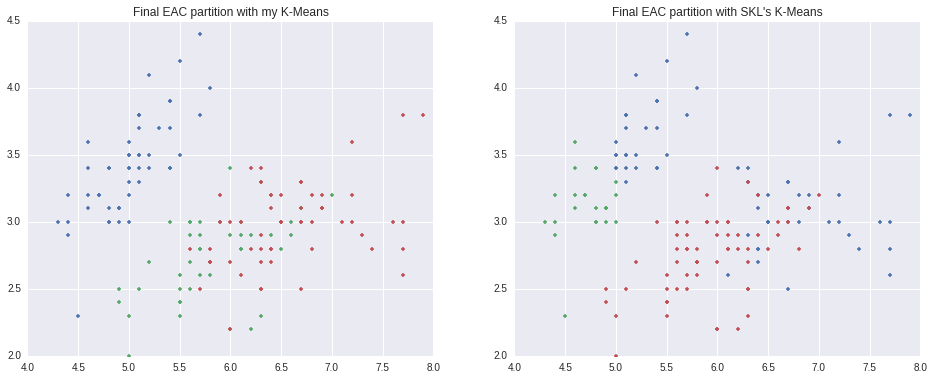

In [10]:
# generate coassoc
prot_mode="random"
assoc_mode='prot' # prot or full
nsamples=data.shape[0]
nprots=nsamples # number of prototypes
gt=iris_gt

partitions_used = partitions_my_rand

myEstimator=eac.EAC(nsamples)
myEstimator.fit(partitions_used,files=False,assoc_mode=assoc_mode, prot_mode=prot_mode, nprot=nprots,build_only=True)

# final clustering with the true number of clusters
true_nclusters = np.unique(gt).shape[0]

# cluster with my K-Means
kmeans_mode = "numpy"

grouper = K_Means3.K_Means(nclusters=true_nclusters, iters="converge", mode=kmeans_mode, cuda_mem='manual',tol=1e-4,max_iters=300)
grouper._centroid_mode = "index"
grouper.fit(myEstimator._coassoc)

# cluster with SKL K-Means
gSKL = KMeans_skl(n_clusters=true_nclusters,n_init=1,init="random")
gSKL.fit(myEstimator._coassoc)

# Hungarian accuracy
myAcc = determine_ci.HungarianIndex(nsamples=nsamples)
myAcc.score(gt,grouper.labels_,format='array')

sklAcc = determine_ci.HungarianIndex(nsamples=nsamples)
sklAcc.score(gt,gSKL.labels_,format='array')


print 'My Accuracy:\t',myAcc.accuracy
print 'SKL Accuracy:\t',sklAcc.accuracy

figEAC=plt.figure(figsize=(16,6))
ax1EAC=figEAC.add_subplot(1,2,1)
ax2EAC=figEAC.add_subplot(1,2,2)

for c in np.unique(grouper.labels_):
    clusterData=grouper.labels_==c
    ax1EAC.plot(data[clusterData,0],data[clusterData,1],'.')
ax1EAC.set_title("Final EAC partition with my K-Means")

for c in np.unique(gSKL.labels_):
    clusterData=gSKL.labels_==c
    ax2EAC.plot(data[clusterData,0],data[clusterData,1],'.')
ax2EAC.set_title("Final EAC partition with SKL's K-Means")

In [11]:
stat_nprots=nsamples
print "{}\t{}\t{}\t{}\t{}".format("type","mean","var","max","min")
print "skl \t",
for metric in k_skl_analysis(partitions_used,files=False,ground_truth=gt,nprots=stat_nprots,rounds=100):
    print "{}\t".format(metric),
print "\nmy  \t",
for metric in k_analysis(partitions_used,files=False,ground_truth=gt,nprots=stat_nprots,iters="converge",rounds=100):
    print "{}\t".format(metric),


type	mean	var	max	min
skl 	0.721466666667	0.0268014044444	0.966666666667	0.433333333333	
my  	0.751466666667	0.0209574044444	0.966666666667	0.426666666667	

# K-Means only

In [12]:
stat_nprots=nsamples
print "{}\t{}\t{}\t{}\t{}".format("type","mean","var","max","min")
print "my  \t",
for metric in stat_my_kmeans(data,true_nclusters,gt,rounds=100):
    print "{}\t".format(metric),
print "\nskl \t",
for metric in stat_skl_kmeans(data,true_nclusters,gt,rounds=100):
    print "{}\t".format(metric),

type	mean	var	max	min
my  	0.801133333333	0.01732716	0.913333333333	0.5	
skl 	0.829733333333	0.0179097066667	0.893333333333	0.5	

# EAC K-Medoids

In [227]:
reload(eac)
#%%debug
partitions_used = partitions_my_rand

# generate coassoc
prot_mode="random"
assoc_mode='full' # prot or full
nprots=50 # number of prototypes

myEstimator=eac.EAC(nsamples)
myEstimator.fit(partitions_used,files=False,assoc_mode=assoc_mode, prot_mode=prot_mode, nprot=nprots,build_only=True)

# final clustering with the true number of clusters
true_nclusters = np.unique(gt).shape[0]

# compute diassociation from co-assoc
diassoc=myEstimator._coassoc.max()-myEstimator._coassoc

#k-medoids
labels,medoids=KMedoids.cluster(diassoc,k=true_nclusters)

# Hungarian accuracy
acc = determine_ci.HungarianIndex(nsamples=nsamples)
acc.score(gt,labels,format='array')

print 'K-Medoids Accuracy:\t',acc.accuracy

K-Medoids Accuracy:	0.86


In [80]:
from timeit import default_timer as timer # timing

class acc_medoids():
    def __init__(self,data,nclusters,gt,timeit=True):
        self.data=data
        self.nsamples=data.shape[0]
        self.nclusters=nclusters
        self.gt=gt
        self.timeit=timeit
        
    def run(self):
        if self.timeit:
            start=timer()
            
        labels,medoids=KMedoids.cluster(self.data,k=self.nclusters)
        
        if self.timeit:
            self.time=timer()-start
        
        # Hungarian accuracy
        acc = determine_ci.HungarianIndex(nsamples=self.nsamples)
        acc.score(self.gt,labels,format='array')

        return acc.accuracy
    
class acc_skl_kmeans():
    def __init__(self,data,nclusters,gt,timeit=True):
        self.data=data
        self.nclusters=nclusters
        self.nsamples=data.shape[0]
        self.gt=gt
        self.timeit=timeit
        
    def run(self):
        if self.timeit:
            start=timer()
        
        # cluster with SKL K-Means
        gSKL = KMeans_skl(n_clusters=self.nclusters,n_init=1,init="random")
        gSKL.fit(self.data)
        
        if self.timeit:
            self.time=timer()-start

        # Hungarian accuracy
        sklAcc = determine_ci.HungarianIndex(nsamples=self.nsamples)
        sklAcc.score(self.gt,gSKL.labels_,format='array')
        
        return sklAcc.accuracy

def stat_analysis(method,rounds=20):
    rAll = np.zeros(rounds)
    times=np.zeros(rounds)
    for r in xrange(rounds):
        rAll[r]=method.run()
        times[r]=method.time
    return rAll.mean(),rAll.var(),rAll.max(),rAll.min(),times.mean()

## Raw diassocs

In [19]:
rounds=100
print '                \t','mean,variance,max,min,time'

diassoc=myEstimator._coassoc.max()-myEstimator._coassoc
x=acc_medoids(diassoc,nclusters=true_nclusters,gt=gt)
print 'diassoc kmedoids\t',stat_analysis(x,rounds=rounds)

x2=acc_skl_kmeans(diassoc,nclusters=true_nclusters,gt=gt)
print 'diassoc kmeans  \t',stat_analysis(x2,rounds=rounds)

x3=acc_medoids(myEstimator._coassoc,nclusters=true_nclusters,gt=gt)
print 'assoc kmedoids  \t',stat_analysis(x3,rounds=rounds)

x4=acc_skl_kmeans(myEstimator._coassoc,nclusters=true_nclusters,gt=gt)
print 'assoc kmeans    \t',stat_analysis(x4,rounds=rounds)

                	mean,variance,max,min,time
diassoc kmedoids	(0.84373333333333334, 0.01749539555555556, 0.95333333333333337, 0.50666666666666671, 0.0023538470268249512)
diassoc kmeans  	(0.75833333333333319, 0.021312333333333332, 0.96666666666666667, 0.48666666666666669, 0.0013846898078918458)
assoc kmedoids  	(0.61266666666666658, 0.0042911111111111101, 0.78666666666666663, 0.47333333333333333, 0.00080596923828125)
assoc kmeans    	(0.75053333333333339, 0.024769048888888881, 0.96666666666666667, 0.43333333333333335, 0.0012806081771850586)


## Normalized diassocs

In [20]:
rounds=100
print '                \t','mean,variance,max,min,time'
diassoc=(myEstimator._coassoc.max()-myEstimator._coassoc)/30
x=acc_medoids(diassoc,nclusters=true_nclusters,gt=gt)
print 'diassoc kmedoids\t',stat_analysis(x,rounds=rounds)

x2=acc_skl_kmeans(diassoc,nclusters=true_nclusters,gt=gt)
print 'diassoc kmeans  \t',stat_analysis(x2,rounds=rounds)

x3=acc_medoids(myEstimator._coassoc,nclusters=true_nclusters,gt=gt)
print 'assoc kmedoids  \t',stat_analysis(x3,rounds=rounds)

x4=acc_skl_kmeans(myEstimator._coassoc,nclusters=true_nclusters,gt=gt)
print 'assoc kmeans    \t',stat_analysis(x4,rounds=rounds)

                	mean,variance,max,min,time
diassoc kmedoids	(0.81646666666666678, 0.020542626666666668, 0.95333333333333337, 0.51333333333333331, 0.002354393005371094)
diassoc kmeans  	(0.73786666666666667, 0.02502033777777778, 0.96666666666666667, 0.43333333333333335, 0.0013648653030395507)
assoc kmedoids  	

KeyboardInterrupt: 

# EAC Single-Link

In [328]:
reload(eac)
#%%debug
partitions_used = partitions_my_rand

# generate coassoc
prot_mode="random"
assoc_mode='full' # prot or full
nprots=50 # number of prototypes

myEstimator=eac.EAC(nsamples)
myEstimator.fit(partitions_used,files=False,assoc_mode=assoc_mode, prot_mode=prot_mode, nprot=nprots,build_only=True)

myEstimator._apply_linkage()
labels = myEstimator._clusterFromLinkage(nclusters=3)

# Hungarian accuracy
acc = determine_ci.HungarianIndex(nsamples=nsamples)
acc.score(gt,labels,format='array')

print 'EAC SL Accuracy:\t',acc.accuracy

EAC SL Accuracy:	0.84
